In [1]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0,'../')
import pyathena as pa
from pyathena import preprocessing

In [6]:
base='/tigress/changgoo/'
problem_id='R8_8pc_metal'
problem_dir=problem_id

> `preprocessing.doall(base, problem_id, problem_dir=None, do_pickling=True, use_yt=True)`


#### This function will do following tasks: 

* #### reoranizing files and creating a parameter file from a restart header. equivalent to call
> `preprocessing.cleanup_directory(base,problem_id,problem_dir=problem_dir)`

  * .hst, .sn --> hst/
  * .zprof --> zprof/
  * .starpar.vtk --> starpar/
  * .rst --> rst/
  * '{}{}/{}.par'.format(base,problem_dir,problem_id) will be created
    
* #### creating merged (along the time axis) zprof files for each thermal phase (using xarray). equivalent to call
> `preprocessing.zprof_to_xarray(base,problem_dir,problem_id)`

* #### creating history data using zprof dumps, including new fields. equivalent to call
> `preprocessing.recal_history(base,problem_dir,problem_id)`

* #### [if do_pickling] creating pickle files for slice and projection (will use yt [if use_yt])

In [7]:
# you only need to run this once
preprocessing.doall(base,problem_id,problem_dir=problem_id,do_pickling=False)

preparing metadata for R8_8pc_metal...
Reading a history file:/tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.hst.p
/tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.hst_cal.p is created
Reading a history file:/tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.sn.p
new /tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.hst_zp.p is created


In [8]:
# Whenever you change the function that creates history (recal_rates/processing_zprof_dump)
#   and want to recreate history based on the revised function,
#   you may need to reload it to reflect your modification to the module loaded in the notebook.
reload(preprocessing)
# Then, you can run this to recreate history
preprocessing.recal_history(base,problem_id,problem_id)

Reading a history file:/tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.hst.p
/tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.hst_cal.p is created
Reading a history file:/tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.sn.p
new /tigress/changgoo/R8_8pc_metal/hst/R8_8pc_metal.hst_zp.p is created


In [9]:
hstzp_filename='{}{}/hst/{}.hst_zp.p'.format(base,problem_dir,problem_id)

In [10]:
import cPickle as p
hstzp=p.load(open(hstzp_filename))

In [13]:
# This has many many fields!
# For full information, please see the source code at ../pyathena/preprocessing.py
# and function processing_zprof_dump
hstzp.shape

(701, 923)

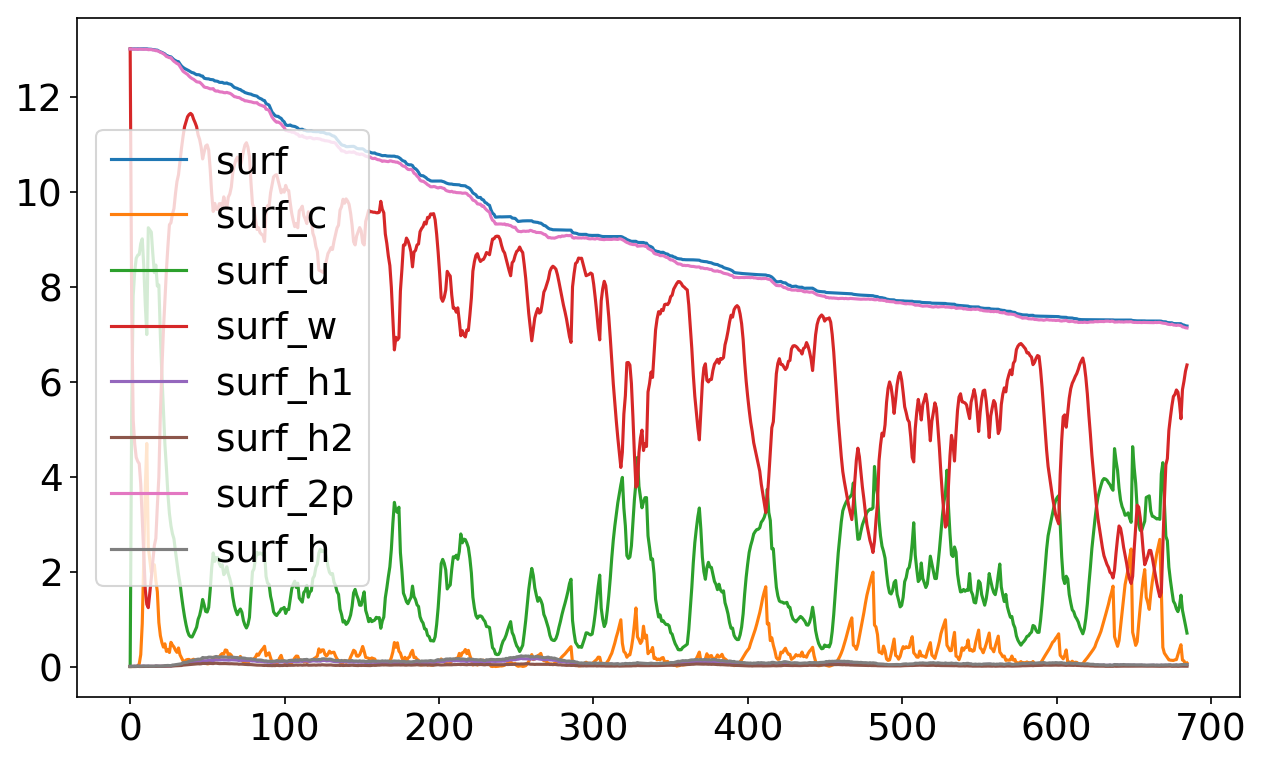

In [16]:
# in the new history, almost all variables have been calculated for 
#    thermal phases, 'c','u','w','h1','h2', 
#    and '2p'='c'+'u'+'w','h'='h1'+'h2'
# e.g., 'surf' stands for the surface density, which has 7 additional fields associated with it.
phases=['','_c','_u','_w','_h1','_h2','_2p','_h']
for ph in phases:
    field_name='surf{}'.format(ph)
    plt.plot(hstzp['tMyr'],hstzp[field_name],label=field_name)
plt.legend()

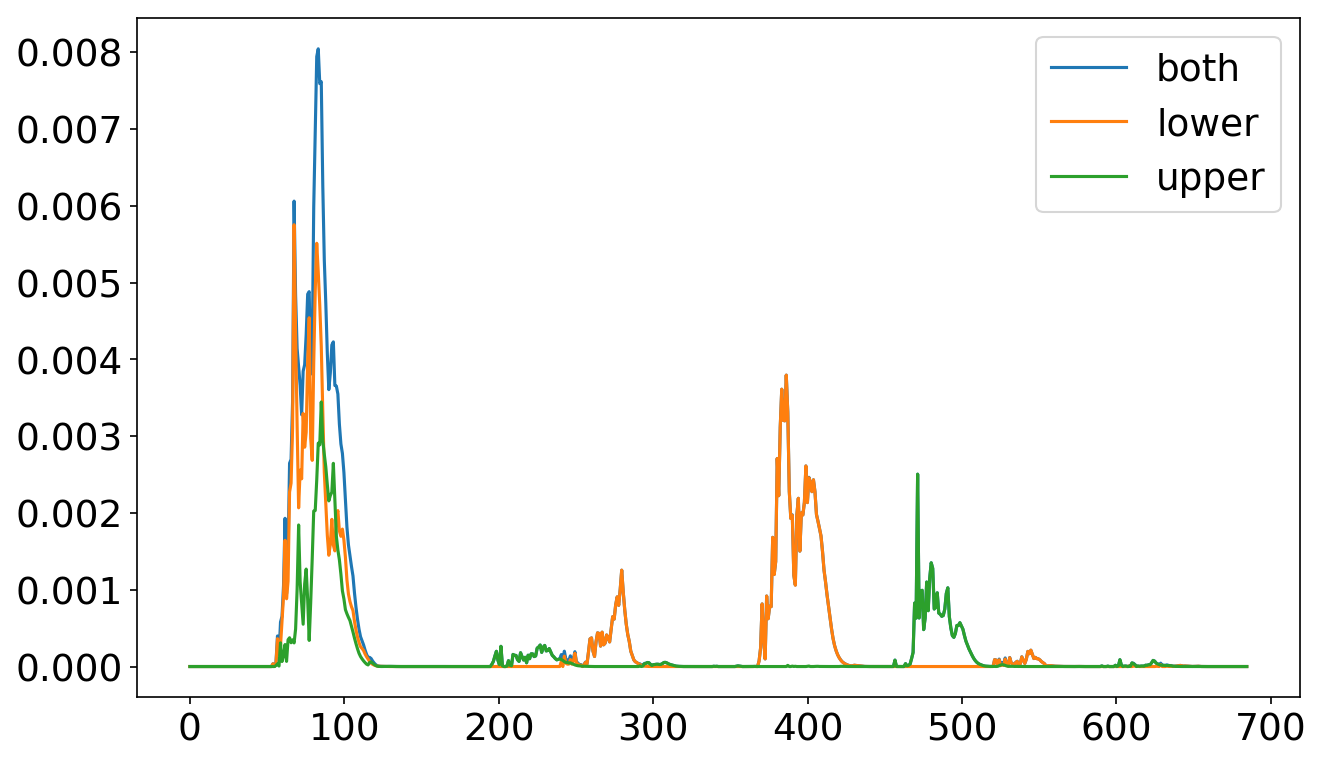

In [17]:
# 'massflux_bd_d' indicates massflux through boundaries (both upper and lower) for density
# 'lbd' = lower boundary
# 'ubd' = upper boundary
# massflux is already converted in the units of Msun/pc^2/Myr
plt.plot(hstzp['tMyr'],hstzp['massflux_bd_d_2p'],label='both')
plt.plot(hstzp['tMyr'],hstzp['massflux_lbd_d_2p'],label='lower')
plt.plot(hstzp['tMyr'],hstzp['massflux_ubd_d_2p'],label='upper')
plt.legend()

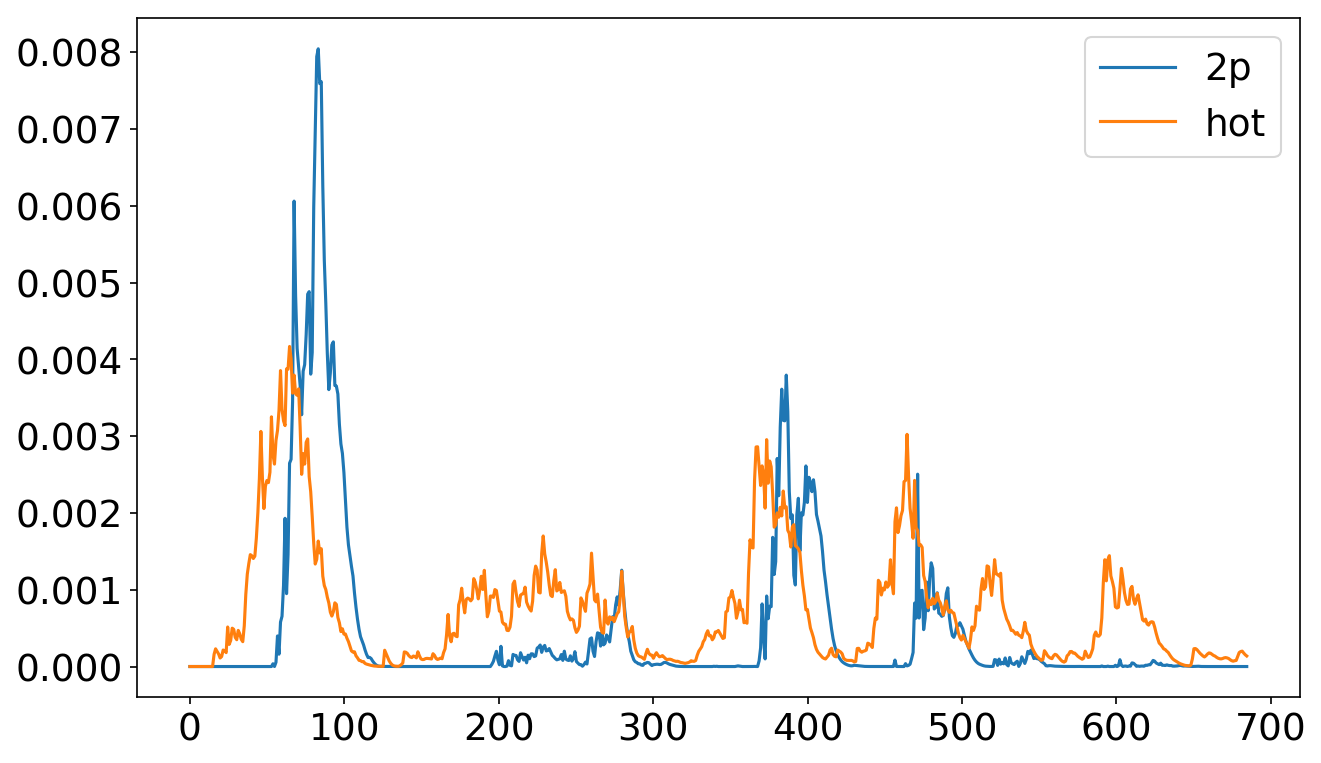

In [18]:
# 'massflux_bd_d' indicates massflux through boundaries (both upper and lower) for density
# 'lbd' = lower boundary
# 'ubd' = upper boundary
# massflux is already converted in the units of Msun/pc^2/Myr
plt.plot(hstzp['tMyr'],hstzp['massflux_bd_d_2p'],label='2p')
plt.plot(hstzp['tMyr'],hstzp['massflux_bd_d_h'],label='hot')
plt.legend()

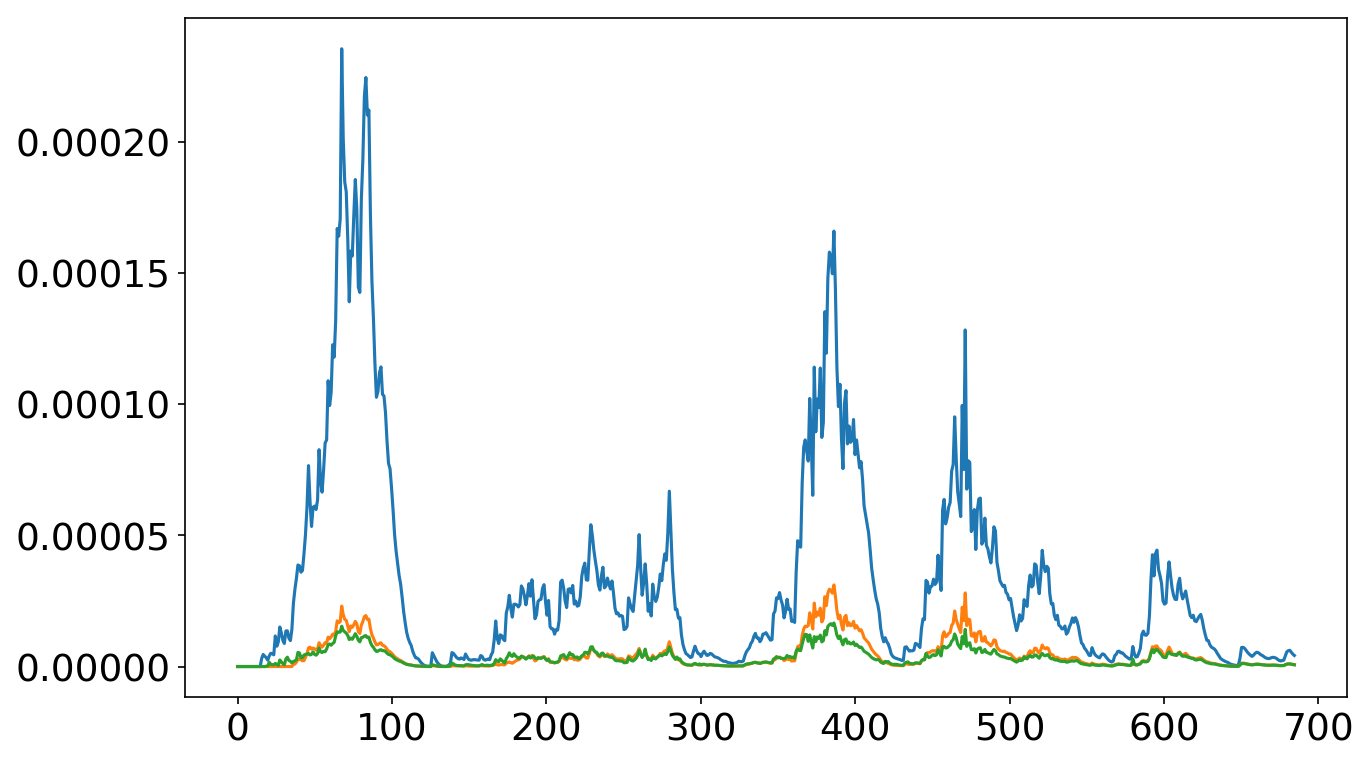

In [19]:
# Why do I need additional subscript 'd' for mass flux?
# Because we now have massfluxes from metals! (you may not have though)
# 's1'=total metal mass flux (rho*Z), including old metal of the ISM + new metal from SNe
# 's2'=flux of metal created by SNe from cluster particles
# 's3'=flux of metal created by SNe from runaway particles

plt.plot(hstzp['tMyr'],hstzp['massflux_bd_s1'])
plt.plot(hstzp['tMyr'],hstzp['massflux_bd_s2'])
plt.plot(hstzp['tMyr'],hstzp['massflux_bd_s3'])

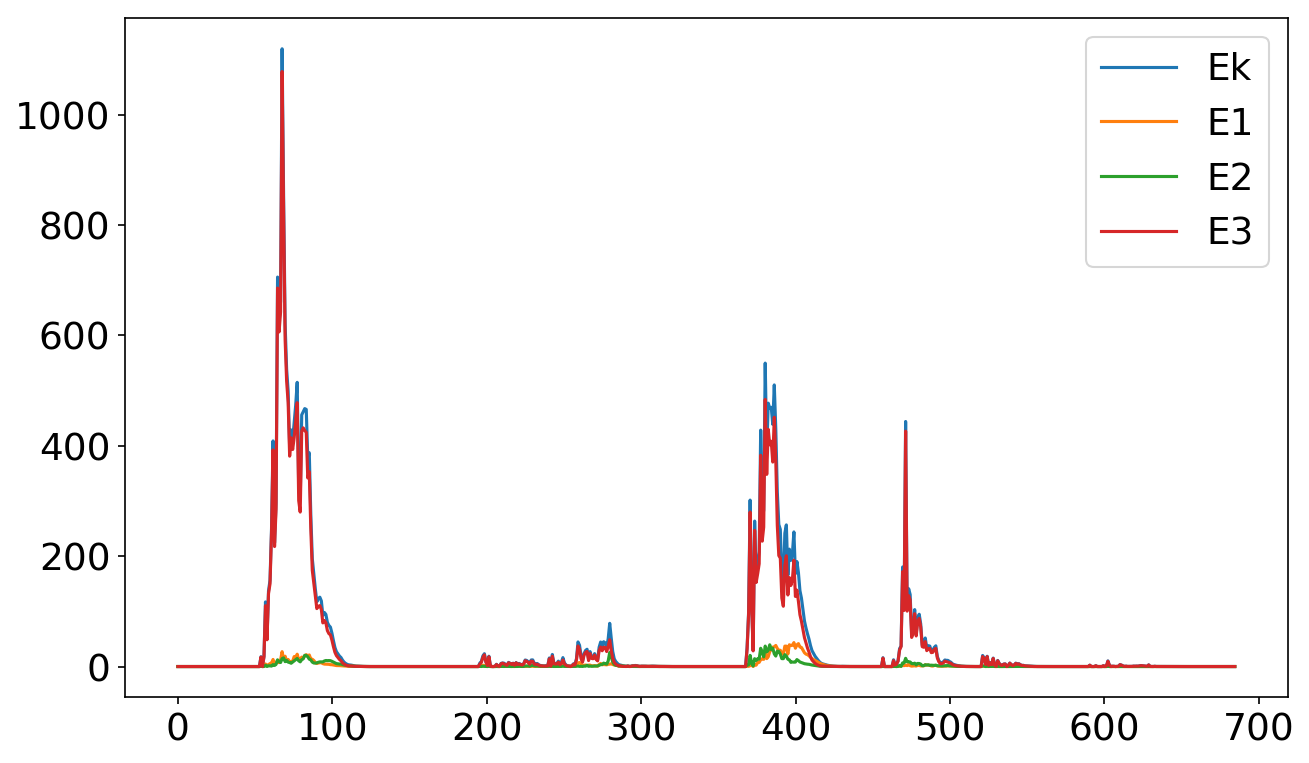

In [20]:
# You can add new fields, for example,
# to get total kinetic energy flux
# Ek1 = 0.5*v_x^2*rho*v_z
# Ek2 = 0.5*v_y^2*rho*v_z
# Ek3 = 0.5*v_z^2*rho*v_z
# Eth = gamma/(gamma-1)*(P/rho)*rho*v_z
# note that the energy flux is in the code units
for ph in phases:
    hstzp['flux_bd_Ek{}'.format(ph)]=hstzp['flux_bd_E1{}'.format(ph)]+\
    hstzp['flux_bd_E2{}'.format(ph)]+hstzp['flux_bd_E3{}'.format(ph)]
for ecomp in ['Ek','E1','E2','E3',]:
    plt.plot(hstzp['tMyr'],hstzp['flux_bd_{}_2p'.format(ecomp)],label=ecomp)
plt.legend()

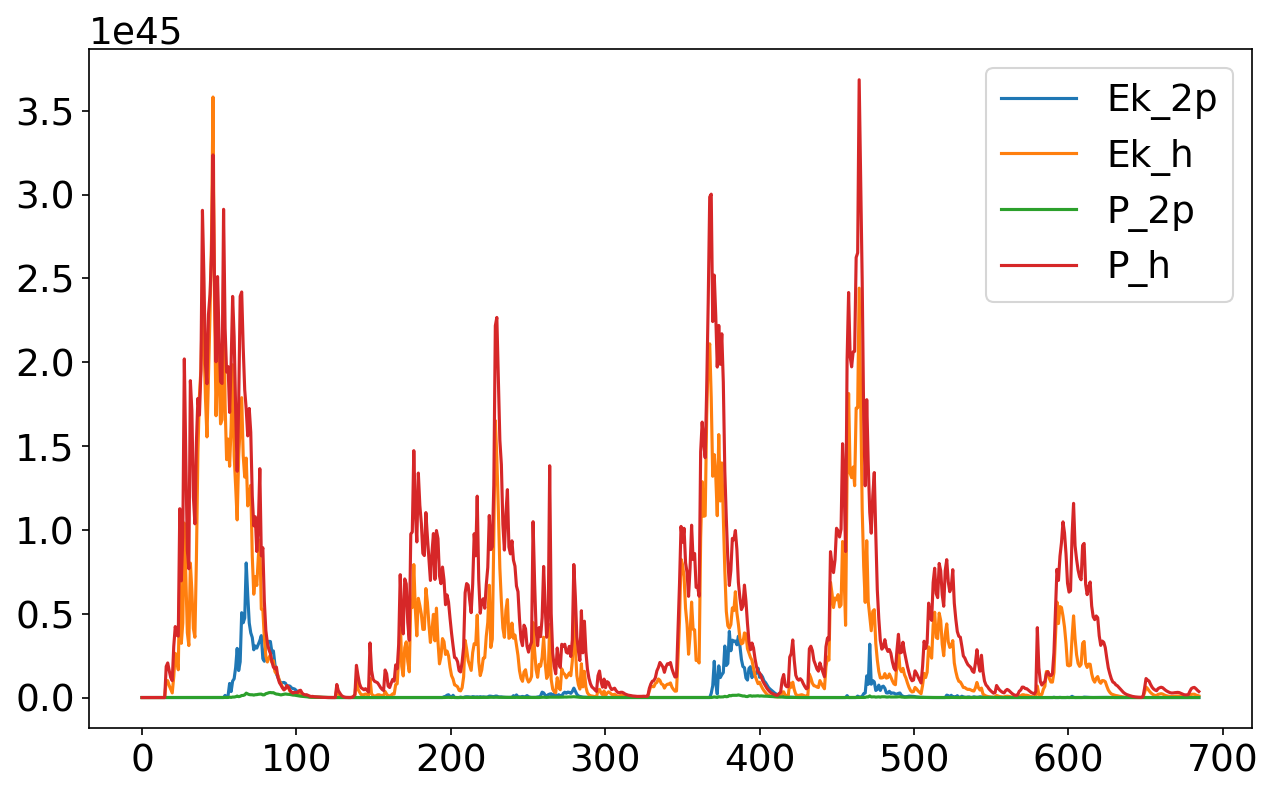

In [23]:
# you may be able to convert energy flux in your favorite units
from pyathena.set_plt import unit,units
eflux_unit=(unit['pressure']*unit['velocity']).to('erg/pc^2/Myr').value
for ecomp in ['Ek','P',]:
    for ph in ['_2p','_h']:
        plt.plot(hstzp['tMyr'],hstzp['flux_bd_{}{}'.format(ecomp,ph)]*eflux_unit,label=ecomp+ph)
plt.legend()